# Importation des bibliothèques 

In [1]:
# Importations standards
import os
import re
import ast
import warnings

# Importations des bibliothèques scientifiques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importations des bibliothèques de scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, jaccard_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, ElasticNet
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Importations des modèles d'autres bibliothèques
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Importations liées à la gestion des jobs
import joblib
from joblib import parallel_backend, dump, Parallel, delayed

# Ignorer les avertissements spécifiques de sklearn
warnings.filterwarnings("ignore")

# Importations des fonctions personnalisées
import utils.utils_supervised as func

## Charger les données nettoyées

Pour la partie supervisée, je vais utiliser les données d'entraînement pour trouver le meilleur modèle. Ensuite, je ferai la prédiction sur les données de test. Donc, je vais charger les données d'entraînement et de test :

#### Les données Train:

In [2]:
train_df = pd.read_csv("data/stack_overflow_data_cleaned_train.csv")
display(train_df.head())
print(train_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"['ios', 'iphone', 'xcode', 'ios', 'simulator',..."
1,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"['docker', 'ubuntu', 'nginx', 'dockerfile', 'a..."
2,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"['javascript', 'reactjs', 'webpack', 'axios', ..."
3,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"['python', 'opencv', 'computer', 'vision', 'oc..."
4,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"['mysql', 'sql', 'ruby', 'on', 'rails', 'index..."


(39881, 5)


#### Les données Test:

In [3]:
test_df = pd.read_csv("data/stack_overflow_data_cleaned_test.csv")
display(test_df.head())
print(test_df.shape)

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"['machine', 'learning', 'neural', 'network', '..."
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"['python', 'sql', 'apache', 'spark', 'datafram..."
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"['c#', 'aspnet', 'rest', 'content', 'type', 'd..."
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"['aspnet', 'iis', 'aspnet', 'web', 'api', 'tas..."
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"['c#', 'winforms', 'user', 'interface', 'drawi..."


(9977, 5)


#### Prétraitement des données de la colonne `train_df['split_tags']` pour construire la variable cible `y` :

Lors du téléchargement des datasets test_df et train_df, le type de la variable de la colonne `split_tags` avait changé, donc il fallait les remettre au bon format :

In [4]:
# Convertir les tags de chaînes de caractères en listes
train_df['split_tags'] = train_df['split_tags'].apply(ast.literal_eval)
test_df['split_tags'] = test_df['split_tags'].apply(ast.literal_eval)

In [5]:
train_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"[ios, iphone, xcode, ios, simulator, instruments]"
1,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"[docker, ubuntu, nginx, dockerfile, apt]"
2,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"[javascript, reactjs, webpack, axios, umijs]"
3,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"[python, opencv, computer, vision, ocr, tesser..."
4,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"[mysql, sql, ruby, on, rails, indexing, mysql,..."


#### Trier les mots par fréquence et sélectionner les 500 plus fréquents dans le corpus `train_df['split_tags']`:

Pour optimiser l'entraînement des modèles supervisés, nous devons limiter le nombre de tags utilisés. Dans cette partie, nous allons identifier et sélectionner les 500 tags les plus fréquents du corpus, basés sur la colonne train_df['split_tags']. Cette approche simplifiera le modèle et améliorera potentiellement sa performance. Ensuite, nous filtrerons les documents pour ne conserver que ceux associés à ces 500 tags principaux :

In [6]:
# Combiner tous les tags en une seule liste de corpus
corpus_tags = [tag for sublist in train_df['split_tags'] for tag in sublist]

# Afficher la fréquence de chaque tag dans le corpus
value_counts_tags = pd.Series(corpus_tags).value_counts()
print("Fréquence de chaque tag dans le corpus :\n\n",value_counts_tags)

Fréquence de chaque tag dans le corpus :

 python        6988
java          6426
javascript    5298
android       5258
c#            4999
              ... 
mixer            1
heapster         1
cov              1
esxi             1
slidify          1
Length: 9958, dtype: int64


In [7]:
vocabulary_tags = list(value_counts_tags.head(500).index)
print(vocabulary_tags)

['python', 'java', 'javascript', 'android', 'c#', 'sql', 'spring', 'html', 'jquery', 'aspnet', 'php', 'ios', 'server', 'c++', 'css', 'mvc', 'google', 'linux', 'studio', 'windows', 'web', 'nodejs', 'database', 'mysql', 'django', 'json', 'string', 'file', 'visual', 'iphone', 'objective', 'arrays', 'ruby', 'http', 'laravel', 'angular', 'apache', 'image', 'data', 'reactjs', 'testing', 'pandas', 'selenium', 'api', 'bootstrap', 'amazon', 'git', 'boot', 'services', 'rails', 'maven', 'swift', 'xcode', 'on', 'hibernate', 'jpa', 'react', 'twitter', 'ajax', 'eclipse', 'angularjs', 'bash', 'postgresql', 'framework', 'docker', 'rest', 'typescript', 'chrome', 'ubuntu', 'dataframe', 'xml', 'numpy', 'macos', 'shell', 'ssl', 'datetime', 'spark', 'date', 'unit', 'oracle', 'gradle', 'command', 'excel', 'list', 'security', 'cocoa', 'core', 'forms', 'entity', 'webdriver', 'code', 'performance', 'memory', 'ui', 'class', 'flutter', 'layout', 'variables', 'line', 't', 'learning', 'interface', 'function', 'aut

Nous allons garder dans la colonne `train_df['split_tags']` uniquement les tags les plus fréquents présents dans `vocabulary_tags`. Pour ce faire, nous appliquons la fonction filter_tags à cette colonne:

In [8]:
# Fonction pour filtrer les tags
def filter_tags(tags):
    return [tag for tag in tags if tag in vocabulary_tags]

In [9]:
# Application de la fonction sur la colonne 'split_tags'
train_df['split_tags'] = train_df['split_tags'].apply(filter_tags)

#### Vérifions les valeurs manquantes après avoir filtré les tags :

In [10]:
func.taux_de_Remplissage_tableau(train_df, affichage_all = True)

Donc pas de valeurs manquantes, nous pouvons continuer.

In [11]:
train_df.head()

,Id,cleaned_title,cleaned_body,combined_title_body,split_tags
0,19245853,xcode iphone simulator look iphone,question device appearance iphone simulator xc...,xcode iphone simulator look iphone question de...,"[ios, iphone, xcode, ios]"
1,55921515,building dockerfile aptget update jailing proc...,docker host ubuntu docker snap dockerfile comm...,building dockerfile aptget update jailing proc...,"[docker, ubuntu, nginx, dockerfile]"
2,72575793,aadsts9002326 crossorigin token redemption isi...,send cross origin request access token react s...,aadsts9002326 crossorigin token redemption isi...,"[javascript, reactjs, webpack, axios]"
3,11489824,choose tesseract opencv,tesseract opencv look tesseract ocr engine ope...,choose tesseract opencv tesseract opencv look ...,"[python, opencv, computer]"
4,3489041,mysqlerror key max key length byte,cause database,mysqlerror key max key length byte cause database,"[mysql, sql, ruby, on, rails, indexing, mysql,..."


Nous remarquons que la taille des listes de la colonne split_tags a changé puisque nous n'avons gardé que les mots fréquents.

#### Transformer les listes de tags en une matrice binaire

Pour préparer les données pour l'entraînement des modèles supervisés, nous devons encoder les tags sous une forme binaire. Pour ce faire, nous utilisons MultiLabelBinarizer de scikit-learn, qui permet de transformer les listes de tags en une matrice binaire. Chaque colonne de cette matrice représente un tag, et chaque ligne indique la présence ou l'absence des tags pour un document donné:

In [12]:
# Initialiser l'encodeur MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Appliquer l'encodeur sur la colonne 'split_tags' du DataFrame train_df
# Cela transforme les listes de tags en une matrice binaire
y = mlb.fit_transform(train_df['split_tags'])

In [13]:
# Affichage des classes identifiées par le MultiLabelBinarizer
print("Classes:", mlb.classes_[:10])

# Affichage de la matrice des étiquettes transformées
print("Transformed Data:\n", y)

Classes: ['access' 'activity' 'ajax' 'algorithm' 'alignment' 'amazon' 'anaconda'
 'android' 'angular' 'angular2']
Transformed Data:
 [[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


#### Trier les mots par fréquence et sélectionner les 500 plus fréquents dans le corpus `df['combined_title_body']`:

In [15]:
# Combiner tout le contenu des corps de texte nettoyés en une seule chaîne de texte
corpus_combined_title_body = " ".join(train_df['combined_title_body'].values).lower()

# Afficher la fréquence de chaque mot dans le corpus des corps de texte nettoyés
corpus_combined_title_body_tokens = corpus_combined_title_body.split()
value_counts_combined_title_body = pd.Series(corpus_combined_title_body_tokens).value_counts()
print("Fréquence de chaque mot dans le corpus des corps de texte nettoyés :\n", value_counts_combined_title_body)

Fréquence de chaque mot dans le corpus des corps de texte nettoyés :
 file             19114
error            17715
code             17381
use              14901
data              8756
                 ...  
entought             1
popperminjs          1
oraconnection        1
cwe                  1
amplayer             1
Length: 64654, dtype: int64


In [16]:
# Créer la liste du vocabulaire des mots les plus fréquents du corpus
vocabulary = list(value_counts_combined_title_body.head(500).index)
print("Les 500 mots les plus fréquents du corpus des corps de texte nettoyés :\n", vocabulary)

Les 500 mots les plus fréquents du corpus des corps de texte nettoyés :
 ['file', 'error', 'code', 'use', 'data', 'value', 'server', 'function', 'method', 'class', 'user', 'set', 'application', 'image', 'object', 'time', 'string', 'project', 'help', 'app', 'page', 'python', 'change', 'table', 'question', 'line', 'test', 'window', 'type', 'found', 'command', 'database', 'request', 'java', 'array', 'thanks', 'version', 'column', 'list', 'solution', 'issue', 'result', 'button', 'try', 'text', 'look', 'return', 'android', 'view', 'update', 'web', 'message', 'query', 'read', 'number', 'script', 'element', 'html', 'spring', 'output', 'library', 'sql', 'api', 'access', 'json', 'simple', 'edit', 'idea', 'form', 'key', 'case', 'javascript', 'build', 'service', 'field', 'right', 'row', 'thing', 'post', 'client', 'property', 'url', 'input', 'date', 'option', 'browser', 'exception', 'jquery', 'install', 'php', 'convert', 'link', 'check', 'controller', 'parameter', 'answer', 'default', 'content', '

In [17]:
vocabulary[:5]

['file', 'error', 'code', 'use', 'data']

#### Vectoriser les textes de la colonne `train_df['combined_title_body']`:

On va utiliser TfidfVectorizer pour vectoriser les textes des questions en utilisant le vocabulaire filtré :

In [18]:
vectorizer_supervised = TfidfVectorizer(vocabulary=vocabulary)
X_tfidf = vectorizer_supervised.fit_transform(train_df['combined_title_body'])

In [19]:
X_tfidf

<39881x500 sparse matrix of type '<class 'numpy.float64'>'
	with 512562 stored elements in Compressed Sparse Row format>

#### Diviser les données en ensembles d'entraînement et de test

Pour évaluer les performances de nos modèles supervisés, on doit diviser nos données en ensembles d'entraînement et de test. on va utiliser la fonction train_test_split de scikit-learn pour effectuer cette division de manière aléatoire, tout en réservant 20% des données pour les tests:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

#### Fonction pour l'entraînement, le calcul de la performance et l'enregistrement des modèles :

Pour évaluer les performances des modèles de classification multi-étiquette, on calcule le score de Jaccard moyen et on évalue les modèles après leur entraînement. Le fichier `init.py` contient deux fonctions : `jaccard` pour le calcul du score de Jaccard et `train_and_evaluate` pour l'entraînement et l'évaluation des modèles:

On initialise ces deux dictionnaires pour stocker les performances des modèles et les modèles entraînés : 

In [22]:
models_performance = {}
trained_models = {}

#### Entraînement Logistic Regression

In [23]:
%%time
model_name = "Logistic Regression"
model = OneVsRestClassifier(LogisticRegression(max_iter=500), n_jobs=-1)

with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)


Training Logistic Regression...
Logistic Regression - F1 Score: 0.41600491586311217
Logistic Regression - Jaccard Score: 0.634172341639209
CPU times: total: 9.23 s
Wall time: 14.2 s


#### Entraînement de SGD Classifier:

In [24]:
%%time
model_name = "SGD Classifier"
model = OneVsRestClassifier(SGDClassifier(max_iter=500), n_jobs=-1)

with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training SGD Classifier...
SGD Classifier - F1 Score: 0.4040752808442348
SGD Classifier - Jaccard Score: 0.630577407052224
CPU times: total: 6.86 s
Wall time: 7.44 s


#### Entraînement de Support Vector Machine:

In [25]:
%%time
model_name = "Support Vector Machine"
model = OneVsRestClassifier(LinearSVC(max_iter=500), n_jobs=-1)
with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training Support Vector Machine...
Support Vector Machine - F1 Score: 0.4472683976736731
Support Vector Machine - Jaccard Score: 0.647617940956451
CPU times: total: 47.9 s
Wall time: 10.7 s


#### Entraînement de XGBoost

In [26]:
%%time
model_name = "XGBoost"
# Mise à jour du modèle avec les meilleurs paramètres trouvés
model = OneVsRestClassifier(XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='logloss'))
with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training XGBoost...
XGBoost - F1 Score: 0.46803085357302227
XGBoost - Jaccard Score: 0.6559013773332233
CPU times: total: 10h 59min 31s
Wall time: 53min 33s


#### Entraînement de Random Forest:

In [27]:
%%time
model_name = "Random Forest"
model = OneVsRestClassifier(RandomForestClassifier(n_estimators=20), n_jobs=-1)
with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training Random Forest...
Random Forest - F1 Score: 0.3787706739076771
Random Forest - Jaccard Score: 0.620371427874497
CPU times: total: 18min 59s
Wall time: 2min 5s


#### Entraînement de LightGBM:

In [28]:
%%time
model_name = "LightGBM"
model = OneVsRestClassifier(LGBMClassifier(n_estimators=500))
with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training LightGBM...
LightGBM - F1 Score: 0.4556589906908378
LightGBM - Jaccard Score: 0.650881801750326
CPU times: total: 5h 6min 56s
Wall time: 25min 27s


#### Entraînement de AdaBoost:

In [29]:
%%time
model_name = "AdaBoost"
model = OneVsRestClassifier(AdaBoostClassifier(n_estimators=20))
with parallel_backend("threading"):
    trained_models[model_name] = func.train_and_evaluate(model_name, model, X_train, y_train, X_test, y_test, models_performance)

Training AdaBoost...
AdaBoost - F1 Score: 0.4311279826464208
AdaBoost - Jaccard Score: 0.6364123426787159
CPU times: total: 10min 4s
Wall time: 2min 7s


#### Convertir les résultats en DataFrame

In [30]:
result_df = pd.DataFrame.from_dict(models_performance, orient="index")
display(result_df)

,F1 Score,Jaccard Score
Logistic Regression,0.416005,0.634172
SGD Classifier,0.404075,0.630577
Support Vector Machine,0.447268,0.647618
XGBoost,0.468031,0.655901
Random Forest,0.378771,0.620371
LightGBM,0.455659,0.650882
AdaBoost,0.431128,0.636412


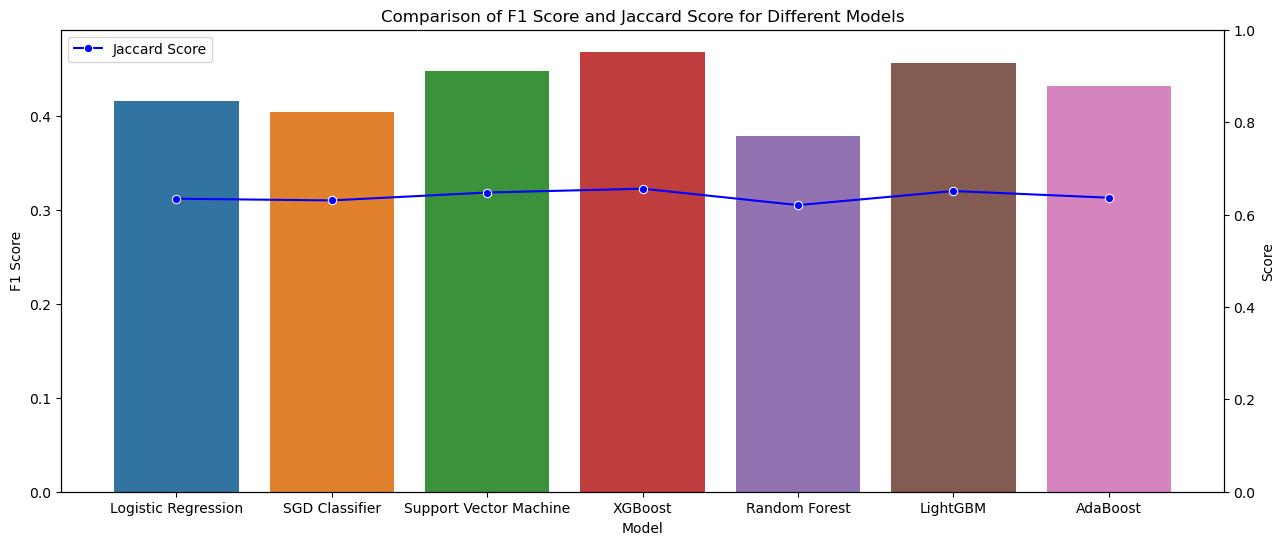

In [13]:
# Fonction pour visualiser les résultats
def plot_results(results, title):
    models = list(results.keys())
    f1_scores = [scores['F1 Score'] for scores in results.values()]
    jaccard_scores = [scores['Jaccard Score'] for scores in results.values()]
    
    results_df = pd.DataFrame({
        'Model': models,
        'F1 Score': f1_scores,
        'Jaccard Score': jaccard_scores
    })
    
    fig, ax1 = plt.subplots(figsize=(15, 6))

    sns.barplot(x='Model', y='F1 Score', data=results_df, ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('F1 Score')
    ax1.set_xlabel('Model')

    ax2 = ax1.twinx()
    sns.lineplot(x='Model', y='Jaccard Score', data=results_df, marker='o', color='blue', label='Jaccard Score', ax=ax2)
    
    ax2.set_ylabel('Score')
    ax2.set_ylim(0, 1)
    ax2.legend(loc='upper left')

    plt.show()



# Visualisation des résultats
plot_results(result_df, 'Comparison of F1 Score and Jaccard Score for Different Models')

#### Sélection du meilleur modèle:

Pour identifier le meilleur modèle parmi ceux que l'on a entraînés, on compare les scores moyens de Jaccard de chaque modèle:

In [31]:
# Initialiser les variables pour suivre le meilleur modèle et son score de Jaccard
best_model = None
best_jaccard = 0
best_model_name = None

# Parcourir tous les modèles entraînés et leurs scores de Jaccard
for model_name, (trained_model, jaccard_avg) in trained_models.items():
    # Si le score de Jaccard actuel est meilleur que le meilleur score enregistré
    if jaccard_avg > best_jaccard:
        # Mettre à jour le meilleur score de Jaccard
        best_jaccard = jaccard_avg
        # Mettre à jour le meilleur modèle
        best_model = trained_model
        # Mettre à jour le nom du meilleur modèle
        best_model_name = model_name

# Afficher le meilleur modèle et son score de Jaccard
print(f'Best Model: {best_model_name}, Jaccard Score: {best_jaccard}')

Best Model: XGBoost, Jaccard Score: 0.6559013773332233


#### Tester le meilleur modèle pour la prédiction des tags avant de l'implémenter dans la future API :

On fait le test avec un seul exemple de la fonction predict_tags :

In [33]:
new_text = train_df['combined_title_body'][4]  # Utiliser le quatrième texte du DataFrame train_df comme exemple

In [34]:
# Exemple de prédiction pour un nouveau texte
predicted_tags = func.predict_tags(new_text, best_model, vectorizer_supervised, mlb)  # Prédire les tags pour le nouveau texte
print("Predicted Tags:", predicted_tags)  # Afficher les tags prédits

Predicted Tags: ['python', 'c#', 'key', 'sql', 'database']


#### Prédire les tags pour toutes les questions de test_df :

Pour améliorer l'efficacité de la prédiction des tags sur un grand nombre de textes, on peut utiliser la parallélisation. La fonction `parallel_predict_tags` de la bibliothèque `joblib` permet d'exploiter les capacités multicœur de la machine, réduisant ainsi le temps nécessaire pour traiter toutes les questions de `test_df`:

In [35]:
%%time
# Paralléliser l'application de la fonction predict_tags
def parallel_predict_tags(df, model, vectorizer, mlb, n_jobs=-1):
    df['predicted_tags'] = Parallel(n_jobs=n_jobs)(
        delayed(func.predict_tags)(text, model, vectorizer, mlb) for text in df['combined_title_body']
    )
    return df

# Appliquer la fonction parallélisée
with parallel_backend("threading"):
    test_df = parallel_predict_tags(test_df, best_model, vectorizer_supervised, mlb)

# Afficher les premières lignes pour vérifier
test_df.head()

CPU times: total: 12h 14min 8s
Wall time: 1h 22min 15s


,Id,cleaned_title,cleaned_body,combined_title_body,split_tags,predicted_tags
0,32177764,weight_decay meta parameter caffe,bvlccaffe git training meta parameter meta par...,weight_decay meta parameter caffe bvlccaffe gi...,"[machine, learning, neural, network, deep, lea...","[validation, control, jdbc, parameters, git]"
1,35870760,pyspark dataframe sqllike clause,filter pyspark dataframe sqllike clause tuple ...,pyspark dataframe sqllike clause filter pyspar...,"[python, sql, apache, spark, dataframe, pyspark]","[dataframe, apache, python, pyspark, spark]"
2,10679214,set contenttype header httpclient request,set header object api allows header try throw ...,set contenttype header httpclient request set ...,"[c#, aspnet, rest, content, type, dotnet, http...","[javascript, api, c#, http, java]"
3,22157596,aspnet web api operationcanceledexception brow...,user load page ajax request hit aspnet web api...,aspnet web api operationcanceledexception brow...,"[aspnet, iis, aspnet, web, api, task, parallel...","[c#, mvc, web, ajax, aspnet]"
4,6100573,draw line object,line control window form draw line line,draw line object line control window form draw...,"[c#, winforms, user, interface, drawing, 2d]","[insert, xaml, binding, c#, winforms]"


#### Sauvegarde de `test_df` avec `predicted_tags` :

In [37]:
test_df.to_csv("data/stack_overflow_data_cleaned_test_predicted_tags_supervised.csv", index=False)

#### Calculer le taux de couverture moyen pour les tags prédits par le modèle supervisé:

Pour évaluer la qualité des prédictions, on calcule le taux de couverture moyen des tags prédits. Cette métrique mesure la proportion de tags corrects prédits par rapport aux tags réels en utilisant la fonction `coverage_rate` sur `test_df`:

In [38]:
# Calculer le taux de couverture moyen pour les tags prédits par le modèle supervisé
average_coverage_supervised = func.coverage_rate(test_df, 'split_tags', 'predicted_tags')
print(f"Taux de couverture moyen pour le modèle supervisé: {average_coverage_supervised:.2f}")


Taux de couverture moyen pour le modèle supervisé: 0.37


### **Conclusion générale:**

En tenant compte des limitations de performance de l'ordinateur, j' ai limité le vocabulaire des vectoriseurs, tant supervisés que non supervisés, aux 500 mots les plus fréquents. Les modèles non supervisés, LDA et NMF, ont atteint un taux de couverture des tags réels de 23 %. En comparaison, le modèle supervisé Xgboost a démontré une performance supérieure avec un taux de couverture de 37 %. Ainsi, le modèle Xgboost s'avère être la méthode la plus efficace, surpassant les approches non supervisées en précision et en adéquation avec les exigences du projet. Par conséquent, pour l'API, j'utiliserai le modèle supervisé pour la prédiction des tags.